## MOOC 학습자 이탈 예측 모델 개발

### 데이터셋 다운로드

In [2]:
import kagglehub
import os
import pandas as pd

dataset_path = kagglehub.dataset_download("rocki37/open-university-learning-analytics-dataset")
print("Dataset downloaded to:", dataset_path)

data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

files = os.listdir(dataset_path)
csv_files = [f for f in files if f.endswith('.csv')]
print("Found CSV files:", csv_files)

saved_files = []
for csv_file in csv_files:
    src_path = os.path.join(dataset_path, csv_file) 
    dest_path = os.path.join(data_folder, csv_file) 
    df = pd.read_csv(src_path) 
    df.to_csv(dest_path, index=False)
    saved_files.append(dest_path)
    print(f"Saved {csv_file} to {dest_path}")

Dataset downloaded to: C:\Users\USER\.cache\kagglehub\datasets\rocki37\open-university-learning-analytics-dataset\versions\1
Found CSV files: ['assessments.csv', 'courses.csv', 'studentAssessment.csv', 'studentInfo.csv', 'studentRegistration.csv', 'studentVle.csv', 'vle.csv']
Saved assessments.csv to data\assessments.csv
Saved courses.csv to data\courses.csv
Saved studentAssessment.csv to data\studentAssessment.csv
Saved studentInfo.csv to data\studentInfo.csv
Saved studentRegistration.csv to data\studentRegistration.csv
Saved studentVle.csv to data\studentVle.csv
Saved vle.csv to data\vle.csv


### 데이터 로드

In [3]:
studentInfo_df = pd.read_csv('./data/studentInfo.csv')[["id_student", "code_module", "highest_education", "studied_credits", "imd_band", "final_result"]]
studentVle_df = pd.read_csv('./data/studentVle.csv')[["id_student", "sum_click", "date"]]
studentAssessment_df = pd.read_csv('./data/studentAssessment.csv')[["id_assessment","id_student", "score"]]
final_merged_data = pd.merge(studentInfo_df, studentAssessment_df, on='id_student', how='inner')

studentVle_agg = studentVle_df.groupby('id_student').agg(
    sum_click=('sum_click', 'sum'),  
    mean_click=('sum_click', 'mean')
).reset_index()

final_merged_data = pd.merge(final_merged_data, studentVle_agg, on='id_student', how='left')

final_merged_data['sum_click'] = final_merged_data['sum_click'].fillna(0)
final_merged_data['mean_click'] = final_merged_data['mean_click'].fillna(0)

### 데이터 전처리

In [4]:
final_merged_data['imd_band'] = final_merged_data['imd_band'].fillna('20-30%')
final_merged_data['score'] = final_merged_data['score'].fillna(0)
final_merged_data['imd_band'] = final_merged_data['imd_band'].replace('10-20', '10-20%')
final_merged_data.to_csv('./data/merged_data.csv', index=False)

### 데이터 분석 및 시각화

In [5]:
withdrawn_rate = final_merged_data["final_result"].value_counts(normalize=True) * 100
print("📌 이탈률 분포:\n", withdrawn_rate)

📌 이탈률 분포:
 final_result
Pass           56.929177
Fail           15.905923
Distinction    14.636382
Withdrawn      12.528519
Name: proportion, dtype: float64


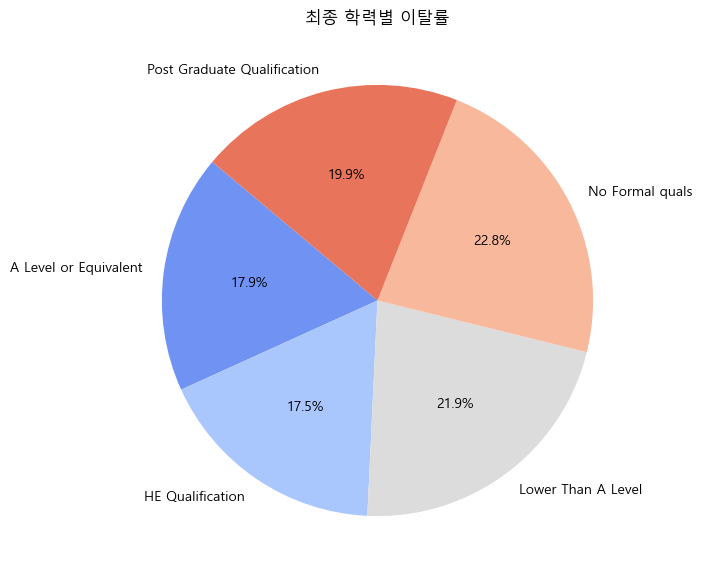

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:/Windows/Fonts/malgunbd.ttf'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

# font_name = "Apple SD Gothic Neo"
# matplotlib.rc('font', family=font_name)

palette = {"Withdrawn": "red", "Pass": "blue", "Fail": "orange", "Distinction": "green"}

education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(7, 7))
plt.pie(education_withdrawn.values, labels=education_withdrawn.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(education_withdrawn)), startangle=140)
plt.title("최종 학력별 이탈률")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_41180\1184413172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")


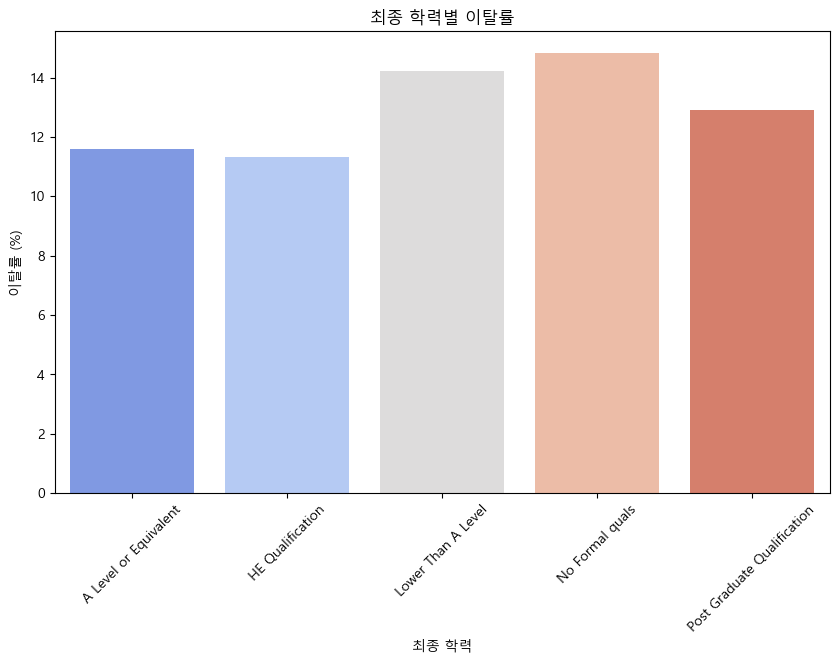

In [7]:
plt.figure(figsize=(10, 6))
education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")
plt.title("최종 학력별 이탈률")
plt.xlabel("최종 학력")
plt.ylabel("이탈률 (%)")
plt.xticks(rotation=45)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_41180\2892628582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")


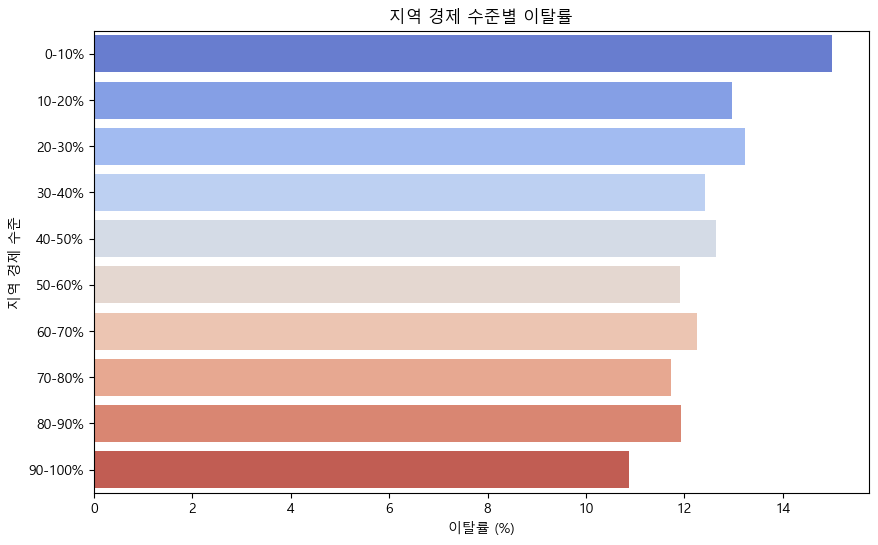

In [8]:
imd_withdrawn = final_merged_data.groupby("imd_band")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(10, 6))
sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")
plt.title("지역 경제 수준별 이탈률")
plt.xlabel("이탈률 (%)")
plt.ylabel("지역 경제 수준")
plt.show()

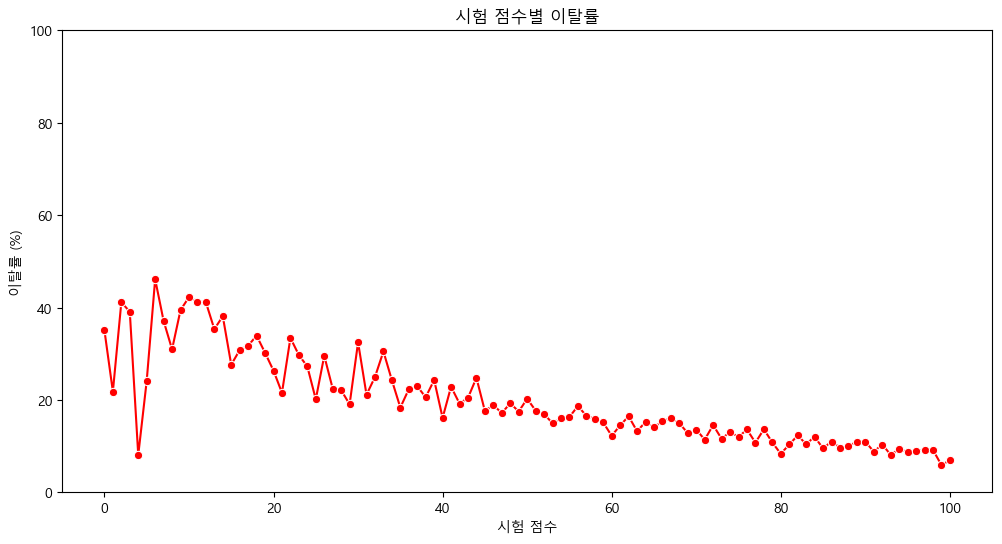

In [9]:
plt.figure(figsize=(12, 6))
score_withdrawn = final_merged_data.groupby("score")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.lineplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red", marker="o")
plt.title("시험 점수별 이탈률")
plt.xlabel("시험 점수")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_41180\2119123669.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


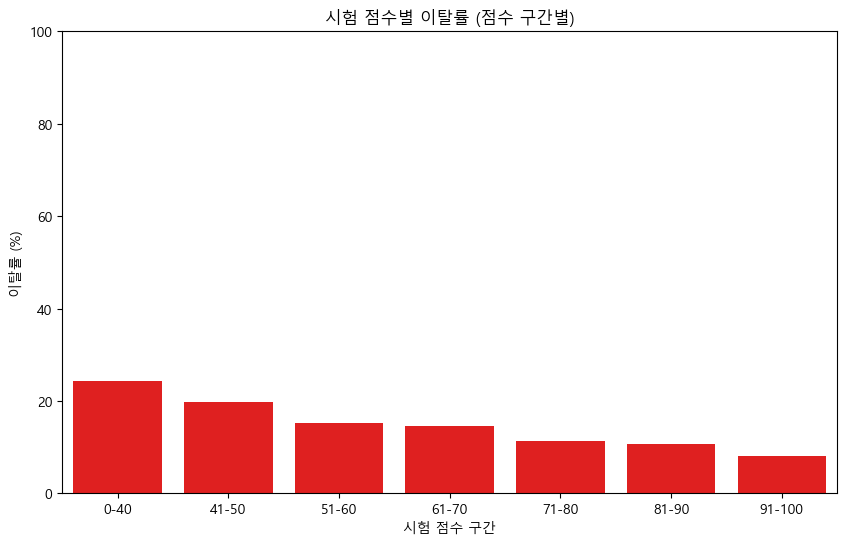

In [10]:
final_merged_data["score_bins"] = pd.cut(final_merged_data["score"], bins=[0, 40, 50, 60, 70, 80, 90, 100], labels=["0-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red")
plt.title("시험 점수별 이탈률 (점수 구간별)")
plt.xlabel("시험 점수 구간")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100) 
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_41180\1035278623.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


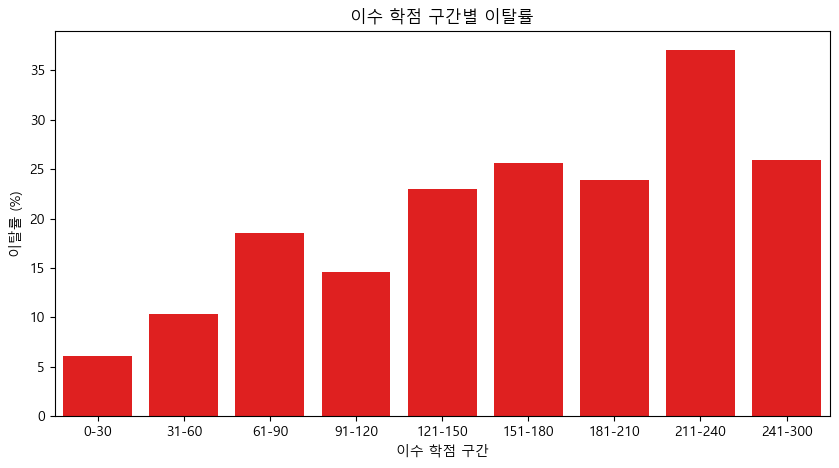

In [11]:
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 210, 240, 300], labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-210", "211-240", "241-300"])
credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_withdrawn.index, y=credit_withdrawn.values, color="red")
plt.title("이수 학점 구간별 이탈률")
plt.xlabel("이수 학점 구간")
plt.ylabel("이탈률 (%)")
plt.show()

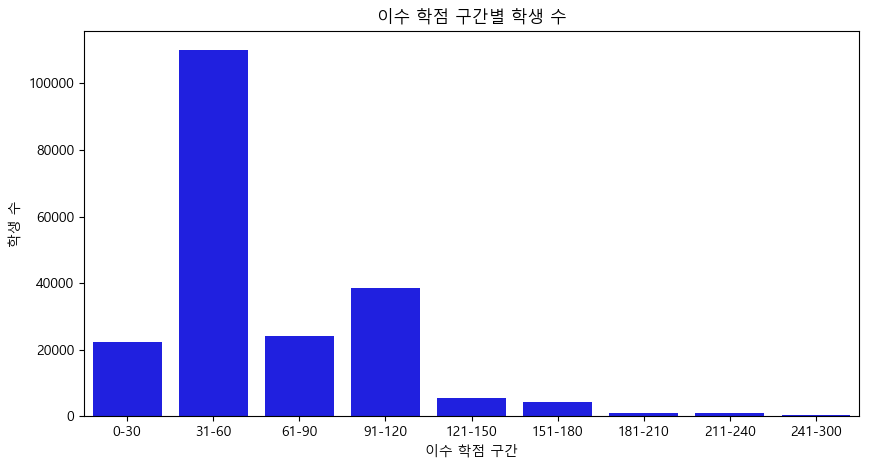

In [12]:
credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_counts.index, y=credit_counts.values, color="blue")
plt.title("이수 학점 구간별 학생 수")
plt.xlabel("이수 학점 구간")
plt.ylabel("학생 수")
plt.show()

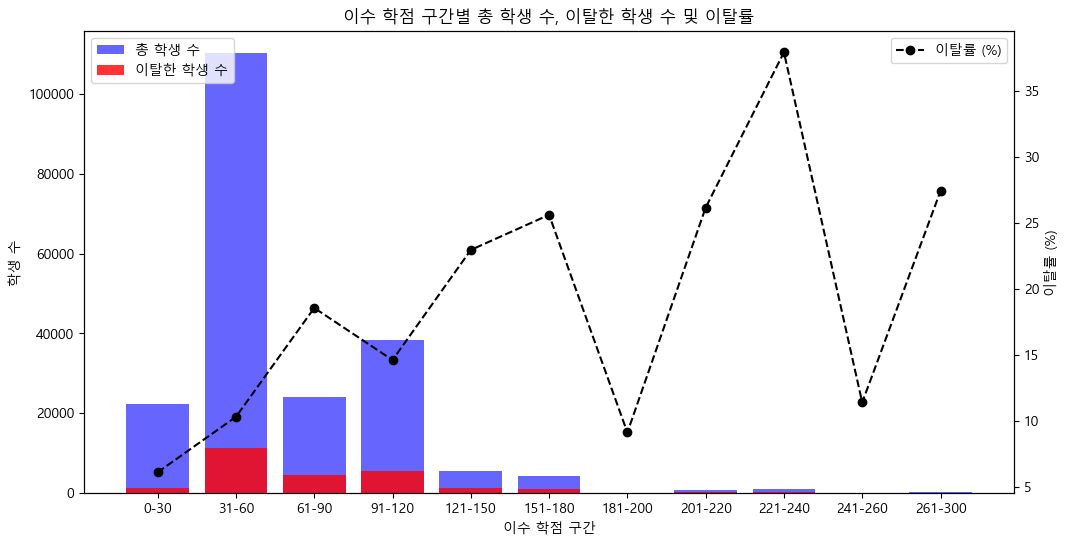

In [13]:
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 200, 220, 240, 260, 300], 
                                          labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-200", "201-220", "221-240", "241-260", "261-300"])

credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()
credit_withdrawn_counts = final_merged_data[final_merged_data["final_result"] == "Withdrawn"]["credit_bins"].value_counts().sort_index()

credit_df = pd.DataFrame({"총 학생 수": credit_counts, "이탈한 학생 수": credit_withdrawn_counts}).fillna(0)
credit_df["이탈률 (%)"] = (credit_df["이탈한 학생 수"] / credit_df["총 학생 수"]) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(credit_df.index, credit_df["총 학생 수"], color="blue", alpha=0.6, label="총 학생 수")
ax1.bar(credit_df.index, credit_df["이탈한 학생 수"], color="red", alpha=0.8, label="이탈한 학생 수")
ax1.set_ylabel("학생 수")
ax1.set_xlabel("이수 학점 구간")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(credit_df.index, credit_df["이탈률 (%)"], color="black", marker="o", linestyle="dashed", label="이탈률 (%)")
ax2.set_ylabel("이탈률 (%)")
ax2.legend(loc="upper right")

plt.title("이수 학점 구간별 총 학생 수, 이탈한 학생 수 및 이탈률")
plt.show()

In [14]:
final_merged_data = final_merged_data.drop(columns=['score_bins', 'credit_bins'], axis=1)


### Data Labeling

- final_result 컬럼을 이진 분류(Binary Classification) 형태로 변환.
- Withdrawn (중도 포기) → 0, 그 외 (Distinction, Fail, Pass) → 1
- 0 = 학습 포기 (Withdrawn)
- 1 = 학습 지속 (Pass, Fail, Distinction)
- code_module과 imd_band는 범주형 변수는 LabelEncoder()를 사용하여 각각의 고유한 문자열을 숫자로 변환.         

In [15]:
from sklearn.preprocessing import LabelEncoder

new_education_encodings = {
    'Post Graduate Qualification': 0,
    'HE Qualification': 1,
    'A Level or Equivalent': 2,
    'Lower Than A Level': 3,
    'No Formal quals': 4
}

final_merged_data['highest_education'] = final_merged_data['highest_education'].map(new_education_encodings)

final_merged_data.head(5)

new_final_result_encodings = {
    'Withdrawn': 0,
    'Distinction': 1,
    'Fail': 1,
    'Pass': 1
}

final_merged_data['final_result'] = final_merged_data['final_result'].map(new_final_result_encodings)

final_merged_data.head(20)

final_merged_data = final_merged_data.copy()
label_encoder = LabelEncoder()

categorical_columns = ["code_module", "imd_band",]
for col in categorical_columns:
    final_merged_data[col] = label_encoder.fit_transform(final_merged_data[col])

Text(0, 0.5, '빈도')

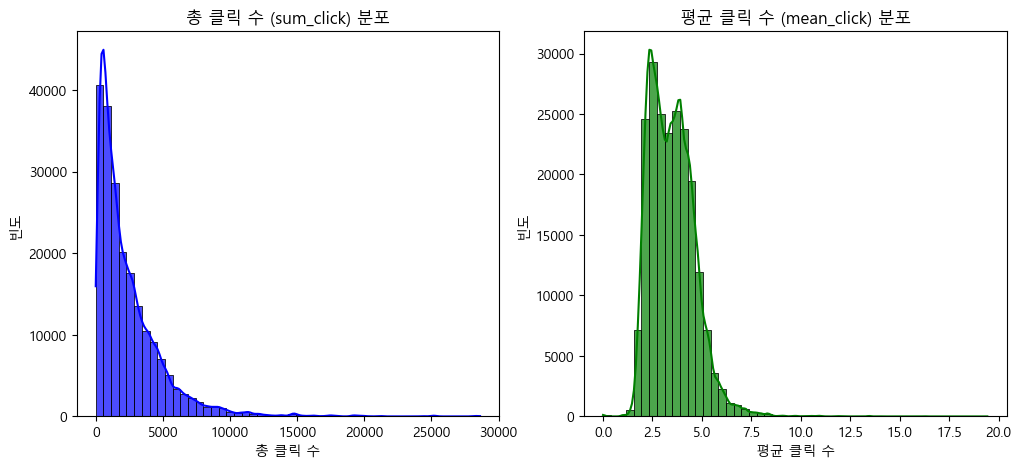

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(final_merged_data["sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("총 클릭 수 (sum_click) 분포")
plt.xlabel("총 클릭 수")
plt.ylabel("빈도")

plt.subplot(1, 2, 2)
sns.histplot(final_merged_data["mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("평균 클릭 수 (mean_click) 분포")
plt.xlabel("평균 클릭 수")
plt.ylabel("빈도")

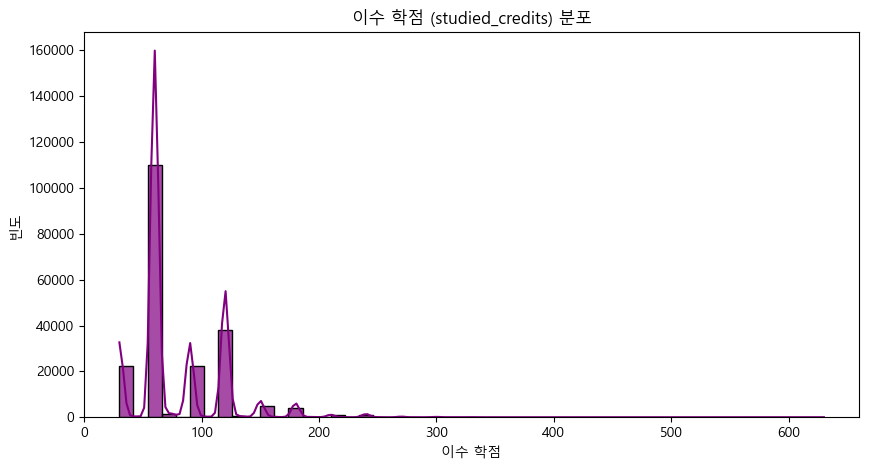

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("이수 학점 (studied_credits) 분포")
plt.xlabel("이수 학점")
plt.ylabel("빈도")
plt.show()

### Data Scaling

- sum_click (총 클릭 수) → 오른쪽 꼬리가 긴 비대칭 분포 (Right-skewed)
- mean_click (평균 클릭 수) → 완만한 비대칭 분포지만, 특정 범위에 밀집

따라서, 분포를 정규 분포에 가깝게 변형하는 Log Scaling 진행

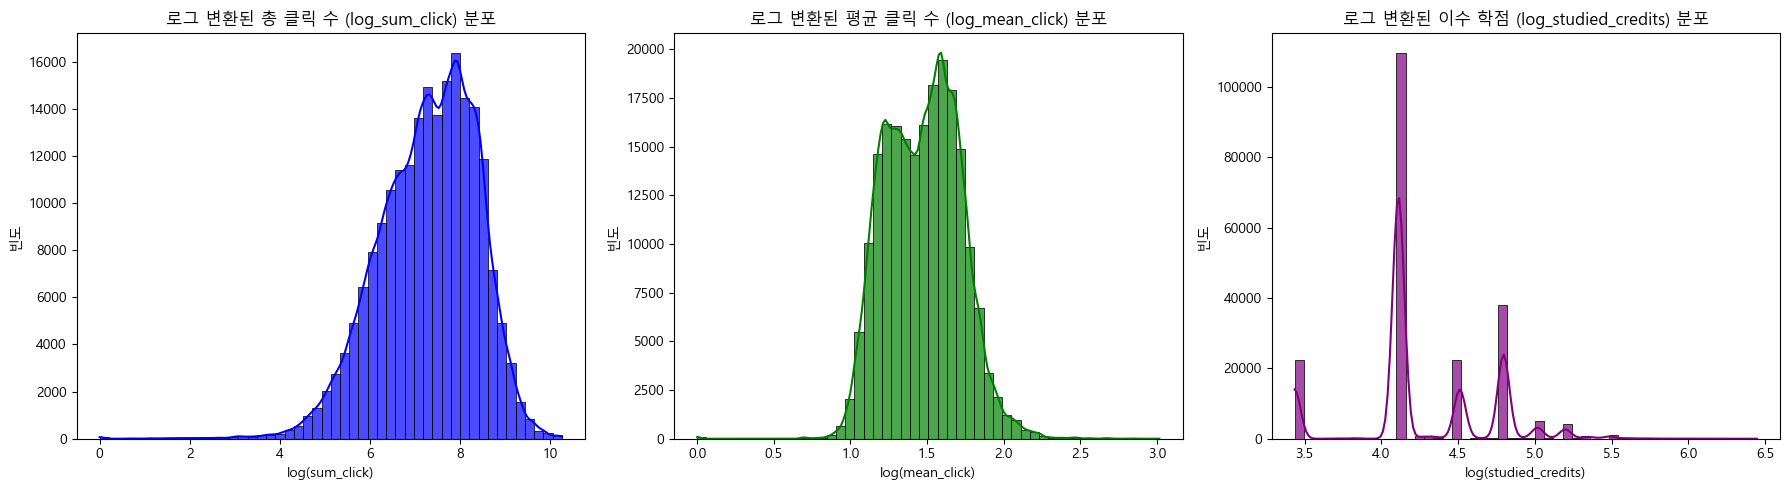

In [18]:
import numpy as np

final_merged_data["log_sum_click"] = np.log1p(final_merged_data["sum_click"])
final_merged_data["log_mean_click"] = np.log1p(final_merged_data["mean_click"])
final_merged_data["log_studied_credits"] = np.log1p(final_merged_data["studied_credits"])

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(final_merged_data["log_sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("로그 변환된 총 클릭 수 (log_sum_click) 분포")
plt.xlabel("log(sum_click)")
plt.ylabel("빈도")

plt.subplot(1, 3, 2)
sns.histplot(final_merged_data["log_mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("로그 변환된 평균 클릭 수 (log_mean_click) 분포")
plt.xlabel("log(mean_click)")
plt.ylabel("빈도")

plt.subplot(1, 3, 3)
sns.histplot(final_merged_data["log_studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("로그 변환된 이수 학점 (log_studied_credits) 분포")
plt.xlabel("log(studied_credits)")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()

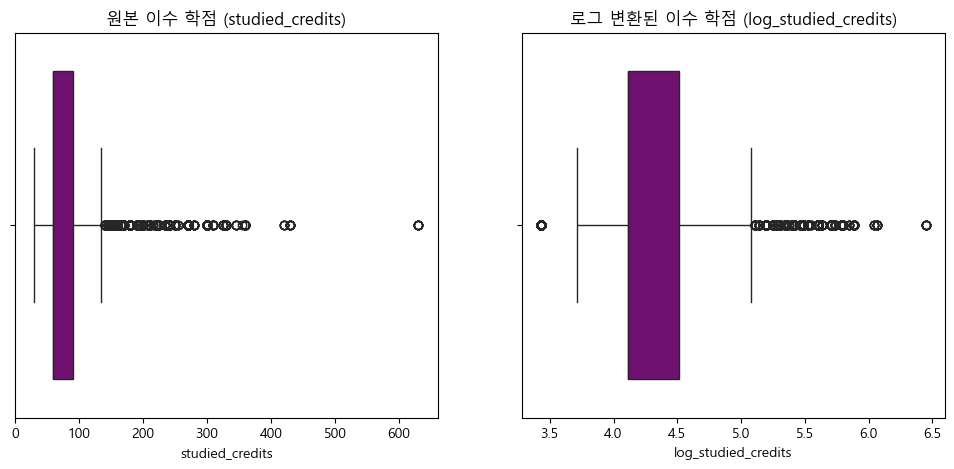

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=final_merged_data["studied_credits"], color="purple")
plt.title("원본 이수 학점 (studied_credits)")

plt.subplot(1, 2, 2)
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

plt.show()

In [20]:
final_merged_data = final_merged_data[final_merged_data["log_studied_credits"] > 3.5]

Text(0.5, 1.0, '로그 변환된 이수 학점 (log_studied_credits)')

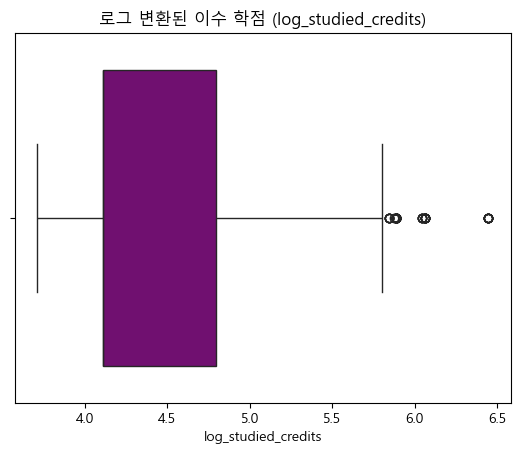

In [21]:
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

#### MinMaxScaler
- 정규 분포를 따르지 않으므로 MinmaxScalar를 사용

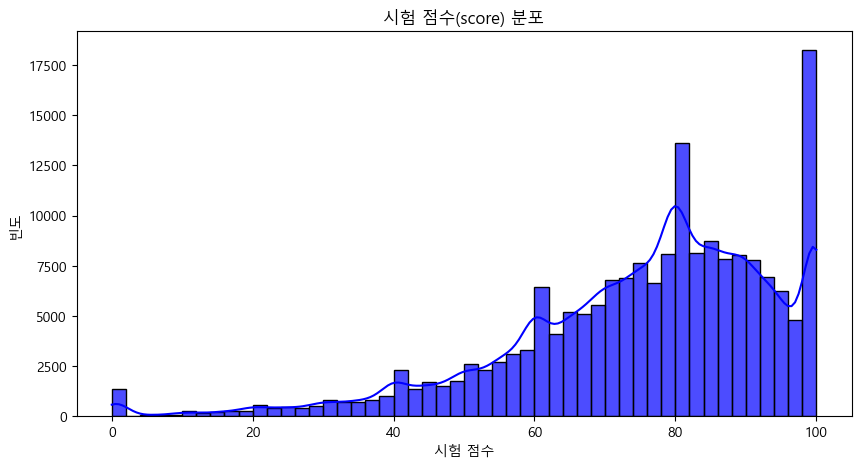

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["score"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("시험 점수(score) 분포")
plt.xlabel("시험 점수")
plt.ylabel("빈도")
plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_merged_data["scaled_studied_credits"] = scaler.fit_transform(final_merged_data[["studied_credits"]])
final_merged_data["scaled_score"] = scaler.fit_transform(final_merged_data[["score"]])

In [24]:
final_merged_data.to_csv('./data/final_merge_data', index=False)

### 학습 데이터

In [25]:
from sklearn.model_selection import train_test_split

sum_clicked_features = ['highest_education', 'imd_band', 'log_sum_click', 'log_studied_credits', 'scaled_score']
mean_clicked_features = ['highest_education', 'imd_band', 'log_mean_click', 'log_studied_credits', 'scaled_score']

sum_x = final_merged_data[sum_clicked_features]
mean_x = final_merged_data[mean_clicked_features]
y = final_merged_data['final_result']

sum_x_train, sum_x_test, y_train, y_test = train_test_split(sum_x, y, test_size=0.1, random_state=42, stratify=y)
mean_x_train, mean_x_test, y_train, y_test = train_test_split(mean_x, y, test_size=0.1, random_state=42, stratify=y)


### 모델 학습

In [26]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier   
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_clf(y_true, y_pred):
    print('정확도 평가')
    print('Accuracy :', accuracy_score(y_true, y_pred))
    print('F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print('Precision :', precision_score(y_true, y_pred, average='weighted'))
    print('Recall :', recall_score(y_true, y_pred, average='weighted'))

### Random Forest

In [28]:
rf_model_1 = RandomForestClassifier(
        random_state=42,
        n_estimators=124,
        max_depth=30,
        min_samples_split=11,
        min_samples_leaf=1,
        max_features=None,
        criterion='entropy'
    )

rf_model_1.fit(sum_x_train, y_train)
y_pred = rf_model_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8917910447761194
F1 Score : 0.879984822608732
Precision : 0.8781755875095064
Recall : 0.8917910447761194


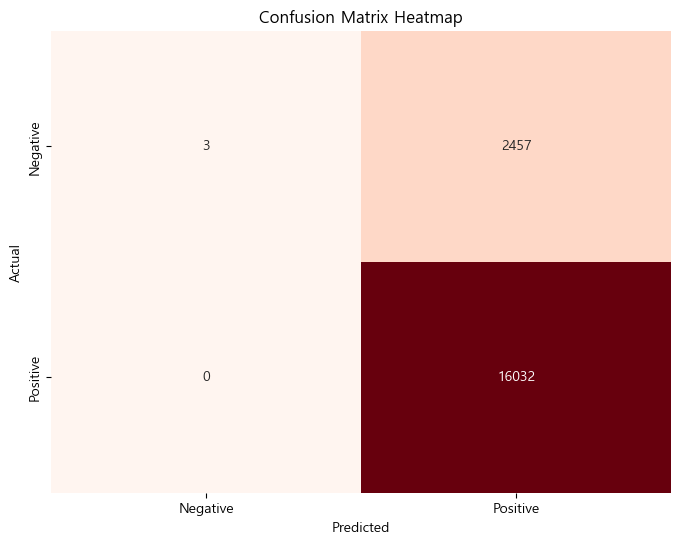

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# 제목과 라벨 추가
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [30]:
rf_model_2 = RandomForestClassifier(
        random_state=42,
        n_estimators=124,
        max_depth=30,
        min_samples_split=11,
        min_samples_leaf=1,
        max_features=None,
        criterion='entropy'
    )

rf_model_2.fit(mean_x_train, y_train)
y_pred = rf_model_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.890655418559377
F1 Score : 0.8763867359556118
Precision : 0.8758181230447374
Recall : 0.890655418559377


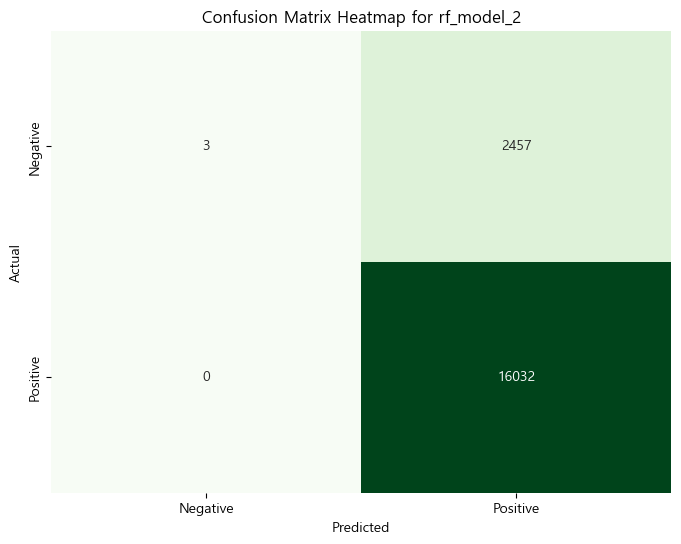

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 예측값을 바탕으로 confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# 제목과 라벨 추가
plt.title('Confusion Matrix Heatmap for rf_model_2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Gredient Boosting

In [31]:
gbm_model_1 = GradientBoostingClassifier(learning_rate= 0.15, 
                                       max_depth= 10,
                                       min_samples_leaf= 2, 
                                       min_samples_split= 5,
                                       n_estimators= 150, 
                                       random_state=42)
gbm_model_1.fit(sum_x_train, y_train)
y_pred = gbm_model_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.899199653904391
F1 Score : 0.8812997891955432
Precision : 0.8896873974337869
Recall : 0.899199653904391


In [32]:
gbm_model_2 = GradientBoostingClassifier(learning_rate= 0.15, 
                                       max_depth= 10,
                                       min_samples_leaf= 2, 
                                       min_samples_split= 5,
                                       n_estimators= 150, 
                                       random_state=42)
gbm_model_2.fit(mean_x_train, y_train)
y_pred = gbm_model_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8965498593986588
F1 Score : 0.8763974249748695
Precision : 0.8867868025986178
Recall : 0.8965498593986588


### Decision Tree

In [33]:
dt_1 = DecisionTreeClassifier(max_depth= None, 
                            max_features= None,
                            min_samples_leaf= 1,
                            min_samples_split=2
                            )
dt_1.fit(sum_x_train, y_train)
y_pred = dt_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8721068570192516
F1 Score : 0.8739523303669836
Precision : 0.8760145350808024
Recall : 0.8721068570192516


In [34]:
dt_2 = DecisionTreeClassifier(max_depth= None, 
                            max_features= None,
                            min_samples_leaf= 1,
                            min_samples_split=2
                            )
dt_2.fit(mean_x_train, y_train)
y_pred = dt_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8662124161799697
F1 Score : 0.8673794833601604
Precision : 0.8686213829454125
Recall : 0.8662124161799697


### KNN

In [35]:
knn_1 = KNeighborsClassifier()
knn_1.fit(sum_x_train, y_train)
y_pred = knn_1.predict(sum_x_test)


evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8702141466580143
F1 Score : 0.8580585351571443
Precision : 0.8522056941085114
Recall : 0.8702141466580143


In [36]:
knn_2 = KNeighborsClassifier()
knn_2.fit(mean_x_train, y_train)
y_pred = knn_2.predict(mean_x_test)


evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8629677698464201
F1 Score : 0.8447428567159253
Precision : 0.8371011802547095
Recall : 0.8629677698464201


In [37]:
xgb_model_1 = XGBClassifier(eval_metric='mlogloss')
xgb_model_1.fit(sum_x_train, y_train)
y_pred = xgb_model_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8755137356694787
F1 Score : 0.8308838630166835
Precision : 0.8618051751727818
Recall : 0.8755137356694787


In [38]:
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(mean_x_train, y_train)
y_pred = xgb_model.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8768115942028986
F1 Score : 0.8329499442686273
Precision : 0.8667515664609939
Recall : 0.8768115942028986


### LightGBM

In [39]:
lgbm_1 = LGBMClassifier(
    num_leaves=40,
    n_estimators=200,
    min_data_in_leaf=20,
    max_depth=10,
    learning_rate=0.2,
    feature_fraction=0.9,
    random_state=42) 

lgbm_1.fit(sum_x_train, y_train)
y_pred = lgbm_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 22138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 166424, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866978 -> initscore=1.874502
[Ligh

In [40]:
lgbm_2 = LGBMClassifier(
    num_leaves=40,
    n_estimators=200,
    min_data_in_leaf=20,
    max_depth=10,
    learning_rate=0.2,
    feature_fraction=0.9,
    random_state=42) 

lgbm_2.fit(mean_x_train, y_train)
y_pred = lgbm_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 22138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 166424, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866978 -> initscore=1.874502
[Ligh

### Logistic Regression

In [41]:
LR1 = LogisticRegression(random_state=42, max_iter=1000, C= 0.01, solver= 'liblinear')
LR1.fit(sum_x_train, y_train)
y_pred = LR1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8670235777633571
F1 Score : 0.8069741056237087
Precision : 0.8207592353851709
Recall : 0.8670235777633571


In [42]:
LR2 = LogisticRegression(random_state=42, max_iter=1000, C= 0.01, solver= 'liblinear')
LR2.fit(mean_x_train, y_train)
y_pred = LR2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8671317326411421
F1 Score : 0.8055878236170453
Precision : 0.8847885736223047
Recall : 0.8671317326411421


In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_results = []

models_predictions = [
    ("Random Forest (sum)", rf_model_1.predict(sum_x_test)),
    ("Random Forest (mean)", rf_model_2.predict(mean_x_test)),
    ("Gradient Boosting (sum)", gbm_model_1.predict(sum_x_test)),
    ("Gradient Boosting (mean)", gbm_model_2.predict(mean_x_test)),
    ("Decision Tree (sum)", dt_1.predict(sum_x_test)),
    ("Decision Tree (mean)", dt_2.predict(mean_x_test)),
    ("KNN (sum)", knn_1.predict(sum_x_test)),
    ("KNN (mean)", knn_2.predict(mean_x_test)),
    ("XGBoost (sum)", xgb_model_1.predict(sum_x_test)),
    ("XGBoost (mean)", xgb_model.predict(mean_x_test)),
    ("LightGBM (sum)", lgbm_1.predict(sum_x_test)),
    ("LightGBM (mean)", lgbm_2.predict(mean_x_test)),
    ("Logistic Regression (sum)", LR1.predict(sum_x_test)),
    ("Logistic Regression (mean)", LR2.predict(mean_x_test))
]

for model_name, y_pred in models_predictions:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    model_results.append([model_name, accuracy, precision, recall, f1])

metrics_df = pd.DataFrame(model_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

metrics_df

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest (sum),0.891791,0.878176,0.891791,0.879985
1,Random Forest (mean),0.890655,0.875818,0.890655,0.876387
2,Gradient Boosting (sum),0.899200,0.889687,0.899200,0.881300
3,Gradient Boosting (mean),0.896550,0.886787,0.896550,0.876397
4,Decision Tree (sum),0.872107,0.876015,0.872107,0.873952
5,Decision Tree (mean),0.866212,0.868621,0.866212,0.867379
6,KNN (sum),0.870214,0.852206,0.870214,0.858059
7,KNN (mean),0.862968,0.837101,0.862968,0.844743
8,XGBoost (sum),0.875514,0.861805,0.875514,0.830884
9,XGBoost (mean),0.876812,0.866752,0.876812,0.832950


In [44]:
plt.figure(figsize=(12, 6))

sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5, cbar=True)

plt.title("Model Performance Heatmap", fontsize=14, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)

plt.show()

ValueError: could not convert string to float: 'Random Forest (sum)'

<Figure size 1200x600 with 0 Axes>